Implementation of Mortal Multi-Armed Bandits
http://papers.nips.cc/paper/3580-mortal-multi-armed-bandits

In [45]:
from __future__ import division
from collections import defaultdict
import scipy.stats

In [46]:
reward_param_mean = 0.40
reward_param_sigma = 0.16

$F(\mu)$ を求める関数、$F(\mu)$は配信実績から作るとあるが、ここはシミュレーションなのでガウス分布で近似してしまう

In [47]:
def F(mu):
    return scipy.stats.norm.cdf(mu, reward_param_mean, reward_param_sigma)

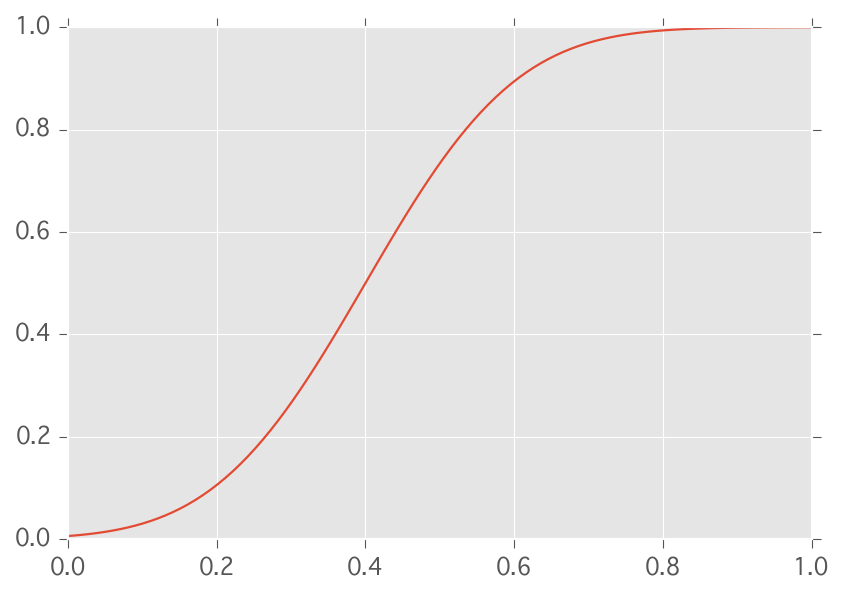

In [48]:
def plot_F():
    X = np.linspace(0, 1, 100)
    Y = F(X)
    plt.plot(X, Y)    
plot_F()

In [49]:
# XはF(mu)を作った分布から作る
X = np.minimum(np.maximum(0, np.random.normal(reward_param_mean, reward_param_sigma, 10000)), 1)

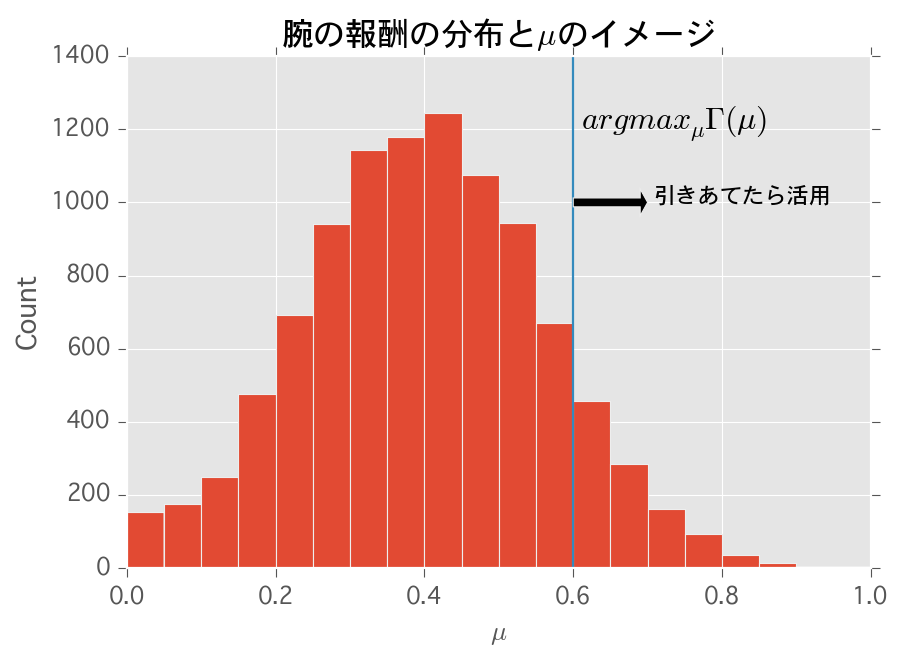

In [50]:
plt.hist(X, bins=20)
plt.plot([0.6, 0.6], [0, 1400])
plt.annotate('', xy=(0.7, 1000), xytext=(0.6, 1000), arrowprops=dict(facecolor='black'))
plt.annotate(u'引きあてたら活用', xy=(0.71, 1000))
plt.annotate(u'$argmax_{\mu}\Gamma(\mu)$', xy=(0.61, 1200), size='x-large')
plt.title(u'腕の報酬の分布と$\mu$のイメージ')
plt.xlabel('$\mu$')
plt.ylabel('Count')

$E[X]$ を求める関数

In [51]:
def E_x():
    return X.mean()

$E[X|X \geq \mu]$ を求める関数

In [52]:
def E_x_given_x_gte_mu(mu):
    ret = X[X >= mu].mean()
    if np.isnan(ret):
        return 0 # NaN
    return ret

$\Gamma(\mu)$ を求める関数

In [53]:
def gamma_mu(mu, L):
    return (E_x() + (1 - F(mu)) * (L - 1) * E_x_given_x_gte_mu(mu)) / (1 + (1 - F(mu)) * (L - 1))

$argmax_{\mu}\Gamma(\mu)$ を求める関数 (かなり適当)

In [54]:
def maximize_gamma_mu(L):
    X = np.linspace(0, 1, 1000)
    Y = np.vectorize(gamma_mu)(X, L)
    return X[Y.tolist().index(max(Y))]

argmax mu: 0.547548
argmax mu: 0.686687
argmax mu: 0.799800


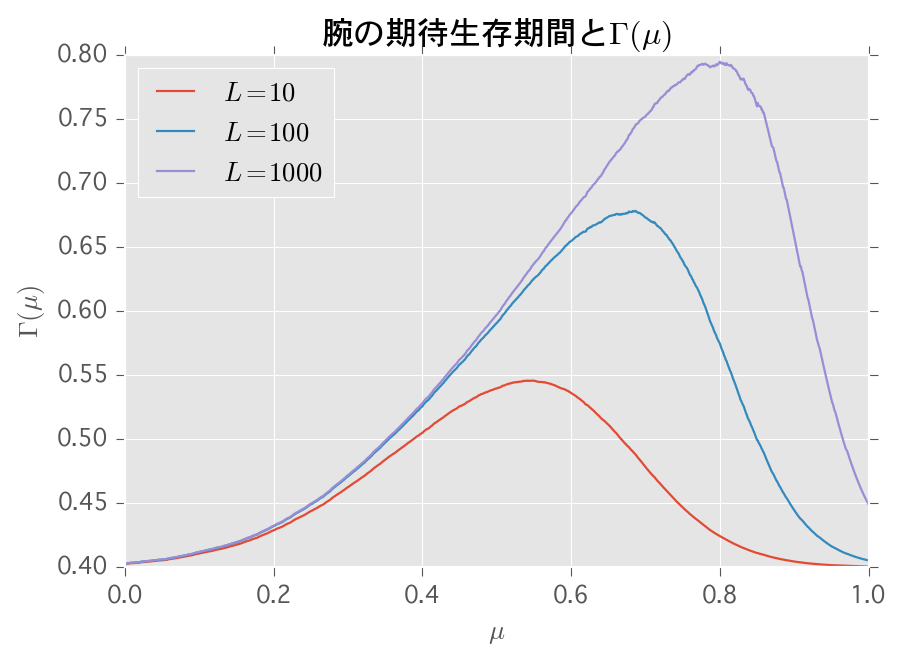

In [55]:
def plot_gamma(L):
    X = np.linspace(0, 1, 1000)
    Y = np.vectorize(gamma_mu)(X, L)
    plt.plot(X, Y)
    
    max_mu = X[Y.tolist().index(max(Y))]
    print('argmax mu: %f' % max_mu)

plot_gamma(1/0.1)
plot_gamma(1/0.01)
plot_gamma(1/0.001)
plt.ylabel('$\Gamma(\mu)$')
plt.legend(['$L = 10$', '$L = 100$', '$L = 1000$'], loc='best')
plt.xlabel('$\mu$')
plt.title(u'腕の期待生存期間と$\Gamma(\mu)$')

### 腕の実装

In [56]:
class MortalArm(object):
    def __init__(self, index, reward, aware):
        self.index = index
        self.reward = reward
        self.aware = aware
        self.is_live = True
        self.is_new = True
        
    def pull(self):
        if not self.is_live:
            raise RuntimeError('Already dead')
            
        self.is_new = False
        if self.aware:
            return self.reward
        else:
            return 1 if np.random.random() < self.reward else 0
    
    def die(self):
        self.is_live = False

In [57]:
class MortalArms(object):
    # 報酬の生成関数 F(mu)を作ったのと同じ分布をつかう
    reward_fn = lambda self: max(0, np.random.normal(0.4, 0.16))
    
    def __init__(self, init_size, lifetime_param, aware=True):
        self.lifetime_param = lifetime_param        
        self.aware = aware # Reward Model
        
        self._arms = []
        self.spawn_arms(init_size)
        
    def update(self):
        dead_count = 0
        for arm in filter(lambda a: a.is_live, self._arms):
            # 生存パラメータpを使って腕を死なせる
            if np.random.random() < self.lifetime_param:
                arm.die()
                dead_count += 1
        
        # 減った分だけ新しく追加
        self.spawn_arms(dead_count)
                        
    def spawn_arms(self, num=1):
        for _ in xrange(num):
            index = len(self._arms)
            self._arms.append(MortalArm(index, self.reward_fn(), aware=self.aware))
    
    @property
    def living_arms(self):
        return filter(lambda a: a.is_live, self._arms)
    
    def select(self, i):
        return self._arms[i]
    
    def select_random(self):jj
        return self.living_arms[np.random.randint(len(self.living_arms))]        
    
    def select_new_one(self):
        new_arms = filter(lambda a: a.is_new and a.is_live, self._arms)
        if new_arms:
            return new_arms[np.random.randint(len(new_arms))]
        return None

## state-ware caseでの実験

In [69]:
class DETOPTStateAwareStrategy(object):
    def __init__(self, p=0.01, arms=100):
        self.arms = MortalArms(arms, p, aware=True)
        self.mu = maximize_gamma_mu(1/p)        
        self.current_arm = None

    def pull(self):
        self.arms.update()
        
        arm = self.current_arm
        if arm is None or arm.is_live == False:
            arm = self.arms.select_new_one()
            
        reward = arm.pull()    
        if reward > self.mu:
            self.current_arm = arm # 活用
        else:
            self.current_arm = None # 次の腕を探索
                
        return reward

In [70]:
class RandomStateAwareStrategy(object):
    def __init__(self, p=0.01, arms=100):
        self.arms = MortalArms(arms, p, aware=True)

    def pull(self):
        self.arms.update()
        return self.arms.select_random().pull()

In [71]:
class EpsilonGreedyAwareStrategy(object):
    def __init__(self, p=0.01, arms=100):
        self.arms = MortalArms(arms, p, aware=True)
        self.epsilon = 0.8
        self.best_arm = None
        self.best_reward = None

    def update_best_arm(self, arm, reward):
        if self.best_reward < reward:
            self.best_arm = arm
        
    def pull(self):
        self.arms.update()
        if np.random.random() > self.epsilon:
            arm = self.arms.select_random() # 探索
        else:
            arm = self.best_arm # 活用
            if arm is None or arm.is_live == False:
                self.best_arm = None
                self.best_reward = 0
                arm = self.arms.select_random()

        reward = arm.pull()
        if self.best_reward < reward:
            self.best_reward = reward
            self.best_arm = arm
        return reward

In [72]:
tests = 2000
p = 0.01
arms = 1000
strategy = DETOPTStateAwareStrategy(p=p, arms=arms)
print('Start DETOPT by mu:', strategy.mu)
DETOPTS_rewards = np.array([strategy.pull() for _ in xrange(tests)])

strategy = RandomStateAwareStrategy(p=p, arms=arms)
random_rewards = np.array([strategy.pull() for _ in xrange(tests)])

strategy = EpsilonGreedyAwareStrategy(p=0.01, arms=1000)
epsilon_rewards = np.array([strategy.pull() for _ in xrange(tests)])

('Start DETOPT by mu:', 0.68668668668668664)


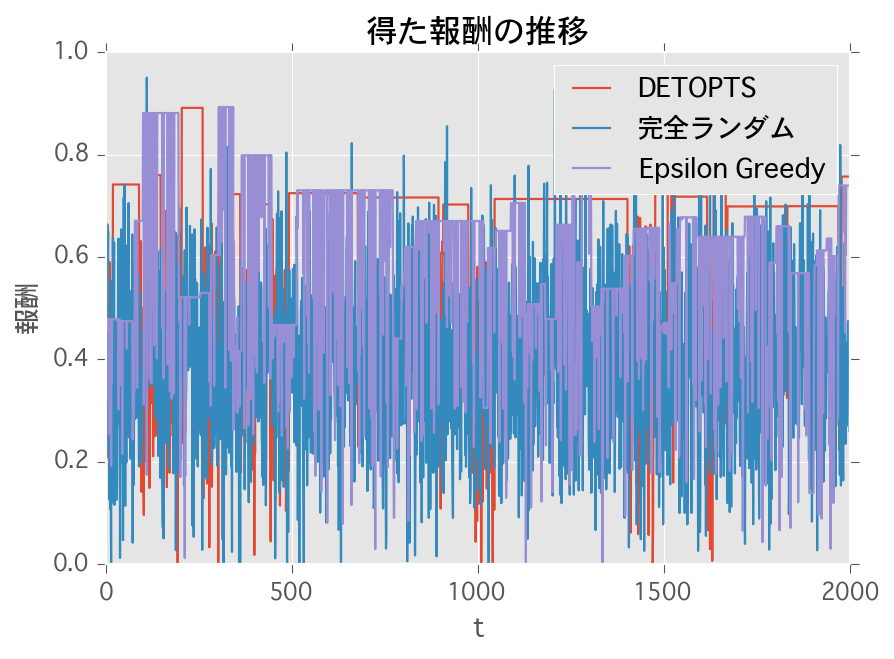

In [73]:
plt.plot(DETOPTS_rewards)
plt.plot(random_rewards)
plt.plot(epsilon_rewards)

plt.legend(['DETOPTS', u'完全ランダム', u'Epsilon Greedy'], loc='best')
plt.xlabel('t')
plt.ylabel(u'報酬')
plt.title(u'得た報酬の推移')

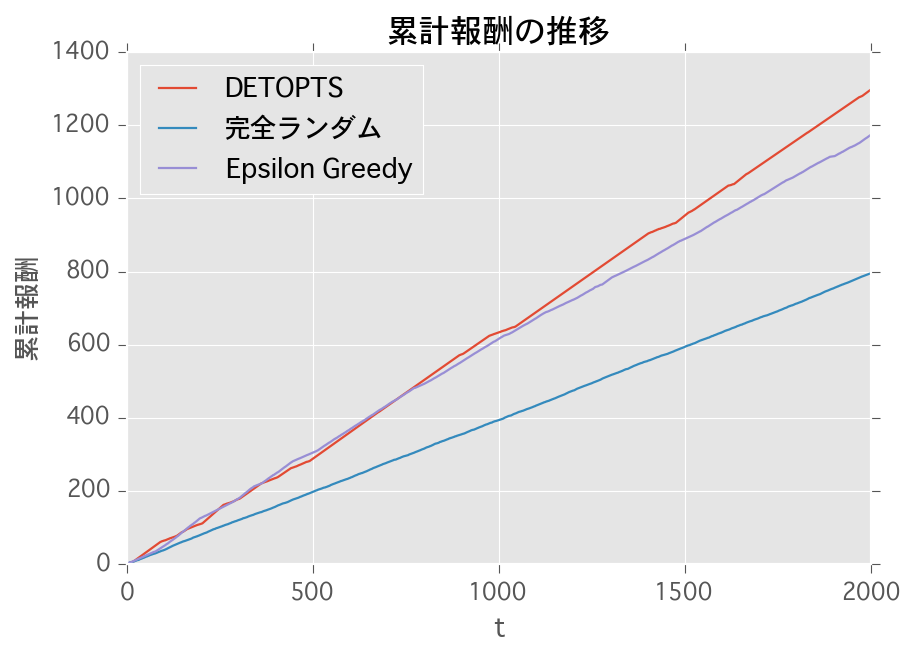

In [74]:
plt.plot(DETOPTS_rewards.cumsum())
plt.plot(random_rewards.cumsum())
plt.plot(epsilon_rewards.cumsum())

plt.legend(['DETOPTS', u'完全ランダム', u'Epsilon Greedy'], loc='best')
plt.xlabel('t')
plt.ylabel(u'累計報酬')
plt.title(u'累計報酬の推移')

## The state-oblivious case での実験

In [21]:
class StochasticStrategy(object):
    def __init__(self, p=0.01, arms=100):
        self.arms = MortalArms(arms, p, aware=False)
        self.mu = maximize_gamma_mu(1/p)
        self.current_arm = None
        self.pulled_count = defaultdict(int)
        self.reward = defaultdict(int)

    def pull(self):
        self.arms.update()
        
        arm = self.current_arm
        if arm is None or arm.is_live == False:
            arm = self.arms.select_new_one()
            self.current_arm = arm
            
        reward = arm.pull()
        self.pulled_count[arm.index] += 1
        
        n = 15
        if self.pulled_count[arm.index] < n:
            self.reward[arm.index] += reward
        elif self.pulled_count[arm.index] == n:
            if self.reward[arm.index] <= n*self.mu:
                self.current_arm = None # 次の腕を探索
        else:
            pass # 引き続き活用
            
        return reward

In [22]:
class StochasticWithEarlyStoppingStrategy(object):
    def __init__(self, p=0.01, arms=100):
        self.arms = MortalArms(arms, p, aware=False)
        self.mu = maximize_gamma_mu(1/p)
        self.current_arm = None
        self.pulled_count = defaultdict(int)
        self.reward = defaultdict(int)

    def pull(self):
        self.arms.update()
        
        arm = self.current_arm
        if arm is None or arm.is_live == False:
            arm = self.arms.select_new_one()
            self.current_arm = arm
            
        reward = arm.pull()
        self.pulled_count[arm.index] += 1
        self.reward[arm.index] += reward
        
        n = 15
        pulled = self.pulled_count[arm.index]
        if pulled < n:
            if (n - pulled) < (n*self.mu - self.reward[arm.index]):
                self.current_arm = None # 次の腕を探索
        elif pulled == n:
            if self.reward[arm.index] <= n*self.mu:
                self.current_arm = None # 次の腕を探索
        else:
            pass # 死ぬまで活用
        return reward

In [23]:
tests = 3000
p = 0.01
arms = 1000
strategy = StochasticStrategy(p=p, arms=arms)
STOCHASTICS_rewards = np.array([strategy.pull() for _ in xrange(tests)])
strategy = StochasticWithEarlyStoppingStrategy(p=p, arms=arms)
StochasticWithEarlyStopping_rewards = np.array([strategy.pull() for _ in xrange(tests)])

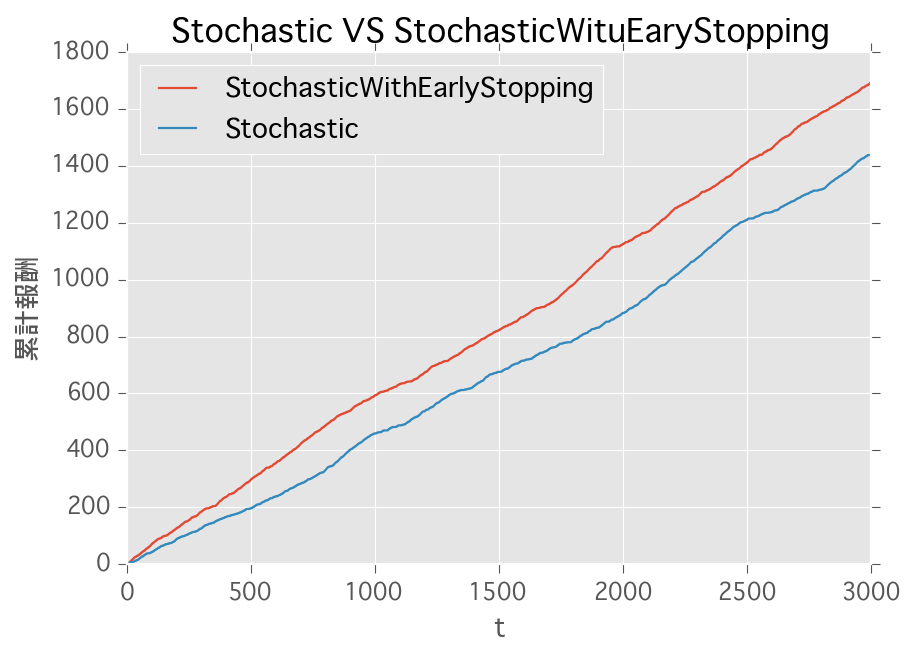

In [24]:
plt.plot(StochasticWithEarlyStopping_rewards.cumsum())
plt.plot(STOCHASTICS_rewards.cumsum())

plt.legend(['StochasticWithEarlyStopping', 'Stochastic'], loc='best')
plt.xlabel('t')
plt.ylabel(u'累計報酬')
plt.title(u'Stochastic VS StochasticWituEaryStopping') 

駄目そうな腕の場合は早々に報酬の推定をやめる、StochasticWithEaryStoppingの方がパフォーマンスが良い

In [39]:
class AdaptiveGreedyStrategy(object):
    def __init__(self, p=0.01, arms=100, c=1):
        self.arms = MortalArms(arms, p, aware=False)
        self.pulled_count = defaultdict(int)
        self.reward = defaultdict(int)
        self.c = c # これはヒューリスティックに決める
        
    @property
    def best_arm(self):
        """ 過去に引いた事がある and まだ生きている腕から推定報酬最大の腕を返す
        """
        mean_rewards = []
        candidate_arm_idxs = []
        for i in self.reward.keys():
            if self.arms.select(i).is_live:
                n = self.pulled_count[i]
                r = self.reward[i]
                candidate_arm_idxs.append(i)
                mean_rewards.append(r/n)
                
        if len(candidate_arm_idxs) == 0:
            return None
        best = mean_rewards.index(max(mean_rewards))
        if best >= 0:
            return self.arms.select(candidate_arm_idxs[best])
        return None
    
    def pull(self):
        self.arms.update()
        
        best_arm = self.best_arm
        if best_arm:
            p = self.reward[best_arm.index]/self.pulled_count[best_arm.index]
            if np.random.random() < min(1, self.c * p):
                arm = best_arm # 活用
            else:
                arm = self.arms.select_random() # 探索
        else:
            arm = self.arms.select_random() # 探索
            
        reward = arm.pull()
        self.pulled_count[arm.index] += 1
        self.reward[arm.index] += reward
        return reward

In [41]:
class UCB1Strategy(object):
    def __init__(self, p=0.01, arms=100, c=1):
        self.arms = MortalArms(arms, p, aware=False)
        self.pulled_count = defaultdict(int)
        self.reward = defaultdict(int)
        
    def select_arm(self):
        arm = self.arms.select_new_one()
        if arm:
            return arm
        
        living_arms = self.arms.living_arms
        
        pull_counts = []
        arm_indexes = []
        for k in filter(lambda i: self.arms.select(i).is_live, self.pulled_count.keys()):
            pull_counts.append(self.pulled_count[k])
            arm_indexes.append(k)
        
        ucb_vals = []
        total_pull = sum(pull_counts)
        for i in arm_indexes:
            bonus = np.sqrt((2 * np.log(total_pull)) / self.pulled_count[i])
            estimate_reward = self.reward[i]/self.pulled_count[i]
            ucb_vals.append(estimate_reward + bonus)
            
        return self.arms.select(arm_indexes[ucb_vals.index(max(ucb_vals))])
            
    def pull(self):
        self.arms.update()
        arm = self.select_arm()
        reward = arm.pull()
        self.pulled_count[arm.index] +=1
        self.reward[arm.index] += reward
        return reward

In [42]:
tests = 2500
ps = [0.05, 0.001]
arms = 1000

ret_stochawe = []
ret_agreedy = []
ret_ucb1 = []
for p in ps:
    strategy = StochasticWithEarlyStoppingStrategy(p=p, arms=arms)
    ret_stochawe.append(np.array([strategy.pull() for _ in xrange(tests)]))

    strategy = AdaptiveGreedyStrategy(p=p, arms=arms)
    ret_agreedy.append(np.array([strategy.pull() for _ in xrange(tests)]))
    
    strategy = UCB1Strategy(p=p, arms=arms)
    ret_ucb1.append(np.array([strategy.pull() for _ in xrange(tests)]))

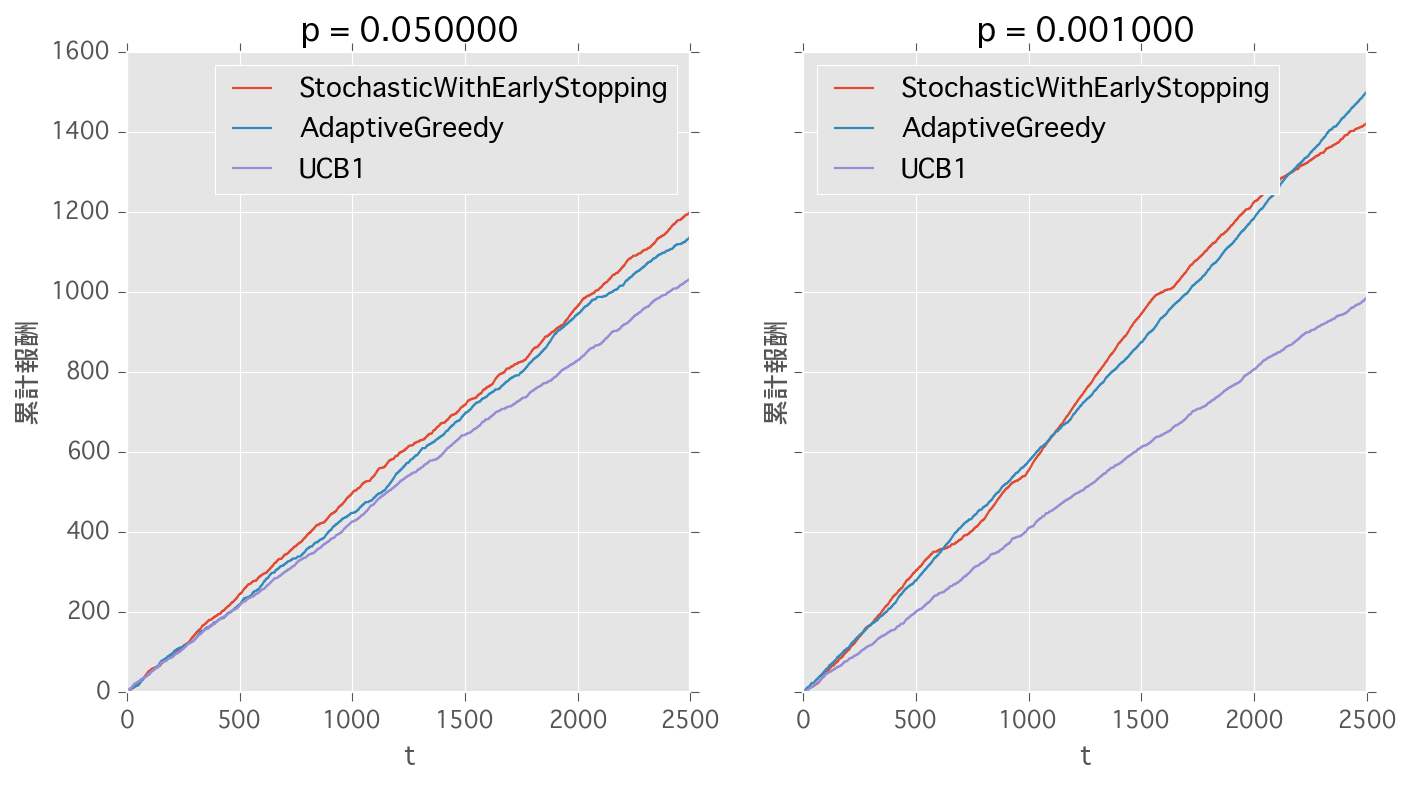

In [43]:
fig, axis = plt.subplots(1, len(ps), figsize=(10, 5), sharey=True)

for i in xrange(len(ps)):
    axis[i].plot(ret_stochawe[i].cumsum())
    axis[i].plot(ret_agreedy[i].cumsum())
    axis[i].plot(ret_ucb1[i].cumsum())
    axis[i].legend(['StochasticWithEarlyStopping', 'AdaptiveGreedy', 'UCB1'], loc='best')
    axis[i].set_xlabel('t')
    axis[i].set_ylabel(u'累計報酬')
    axis[i].set_title(u'p = %f' % ps[i])

論文の通り、ADAPTIVE GREEDYとほぼ同じパフォーマンスになる